In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cancer-details/rf.csv


In [2]:
# Focus on deterministic runs

import random
import numpy as np
import os
import tensorflow as tf
import gc

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(14242)

In [3]:
cddf = pd.read_csv("/kaggle/input/cancer-details/rf.csv")

## Check for Data Cleansing requirements - there are none, nothing missing or NA

The basic info tells us the data is clean, we likely don't need to do cleanup work. Only the diagnosis is categorial, at that it is binary.

In [4]:
print (cddf.info())
print (cddf.head(10))
print (cddf.nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

## Visualization using histograms (then scatter plots)

Plotting all 30 togetheris too much for visualizing, however it does readily break down into at least three major parts of 10 features each. The plotting is broken down by the 10 features each for which a mean, and se, and a worst case are reported.

SE is more skewed than the Mean and Worst case groupings of features. Mutual Information, shown later, will also show SE to be less relevant. No attempt is made to normalize SE (boxcox might be applied in further research).

In [5]:
submean = [ 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 
            'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']
subse = [ 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 
            'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se']
subworst = [ 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 
            'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst']
# cddf.drop(['Unnamed 32'], axis=1, inplace=True)

The out of the box desriptive statistics appear below. The data is likely skewed, looking at histograms below these descriptive statistics.

In [6]:
print(cddf[submean].describe())
print(cddf[subse].describe())
print(cddf[subworst].describe())

       radius_mean  texture_mean  perimeter_mean    area_mean  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

The histograms suggest anywhere from a small amount to a large amount of right skewed data.

[[<AxesSubplot:title={'center':'radius_mean'}>
  <AxesSubplot:title={'center':'texture_mean'}>
  <AxesSubplot:title={'center':'perimeter_mean'}>]
 [<AxesSubplot:title={'center':'area_mean'}>
  <AxesSubplot:title={'center':'smoothness_mean'}>
  <AxesSubplot:title={'center':'compactness_mean'}>]
 [<AxesSubplot:title={'center':'concavity_mean'}>
  <AxesSubplot:title={'center':'concave points_mean'}>
  <AxesSubplot:title={'center':'symmetry_mean'}>]
 [<AxesSubplot:title={'center':'fractal_dimension_mean'}> <AxesSubplot:>
  <AxesSubplot:>]]
[[<AxesSubplot:title={'center':'radius_se'}>
  <AxesSubplot:title={'center':'texture_se'}>
  <AxesSubplot:title={'center':'perimeter_se'}>]
 [<AxesSubplot:title={'center':'area_se'}>
  <AxesSubplot:title={'center':'smoothness_se'}>
  <AxesSubplot:title={'center':'compactness_se'}>]
 [<AxesSubplot:title={'center':'concavity_se'}>
  <AxesSubplot:title={'center':'concave points_se'}>
  <AxesSubplot:title={'center':'symmetry_se'}>]
 [<AxesSubplot:title={'cen

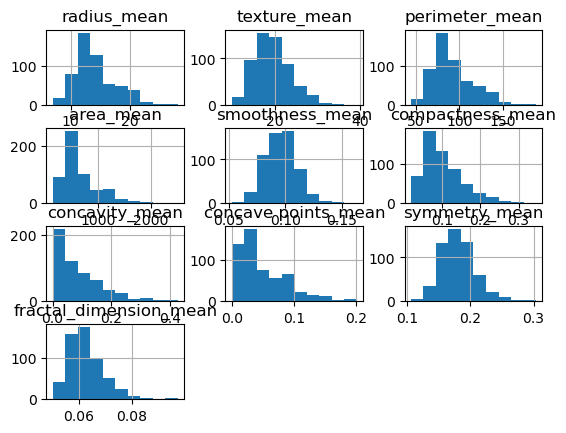

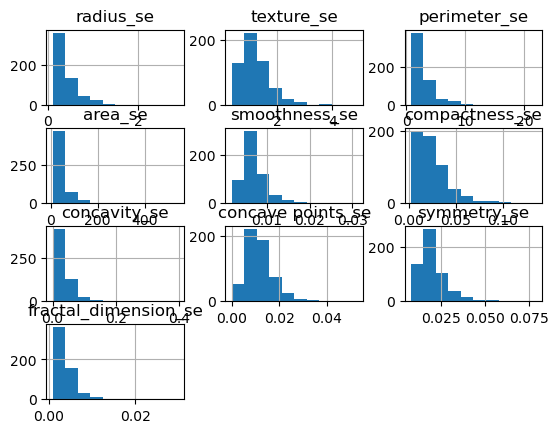

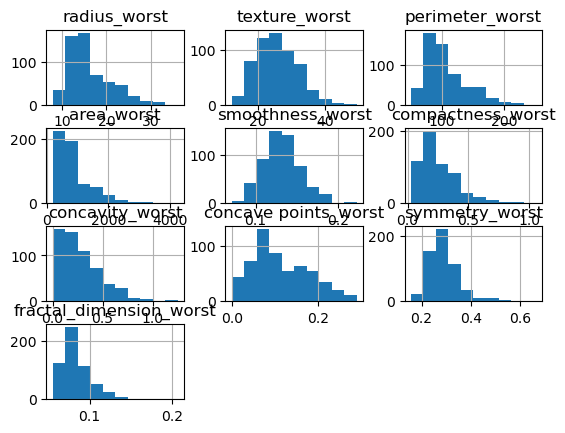

In [7]:
print(cddf[submean].hist())
print(cddf[subse].hist())
print(cddf[subworst].hist())

The scatter plots seem to suggest the diagnosis tend to be clustered with some overlap. We may not need all of the data, as 30 features with three different results (mean, se, and worst case) are likely overlapping or potentially co-linear (though to be sure we need to crunch more numbers). The clearest data seems to come from mean and worst scatter plots, especially for the 1st (radius), 3rd (perimeter), 4th (area), 7th (concavity), and 8th (concave points) features. The 1st, 3rd, and 4th are probably in some way correlated, and the same may be true for 7th and 8th. See the scatter plots below and then continue on to Mutual Information regression.

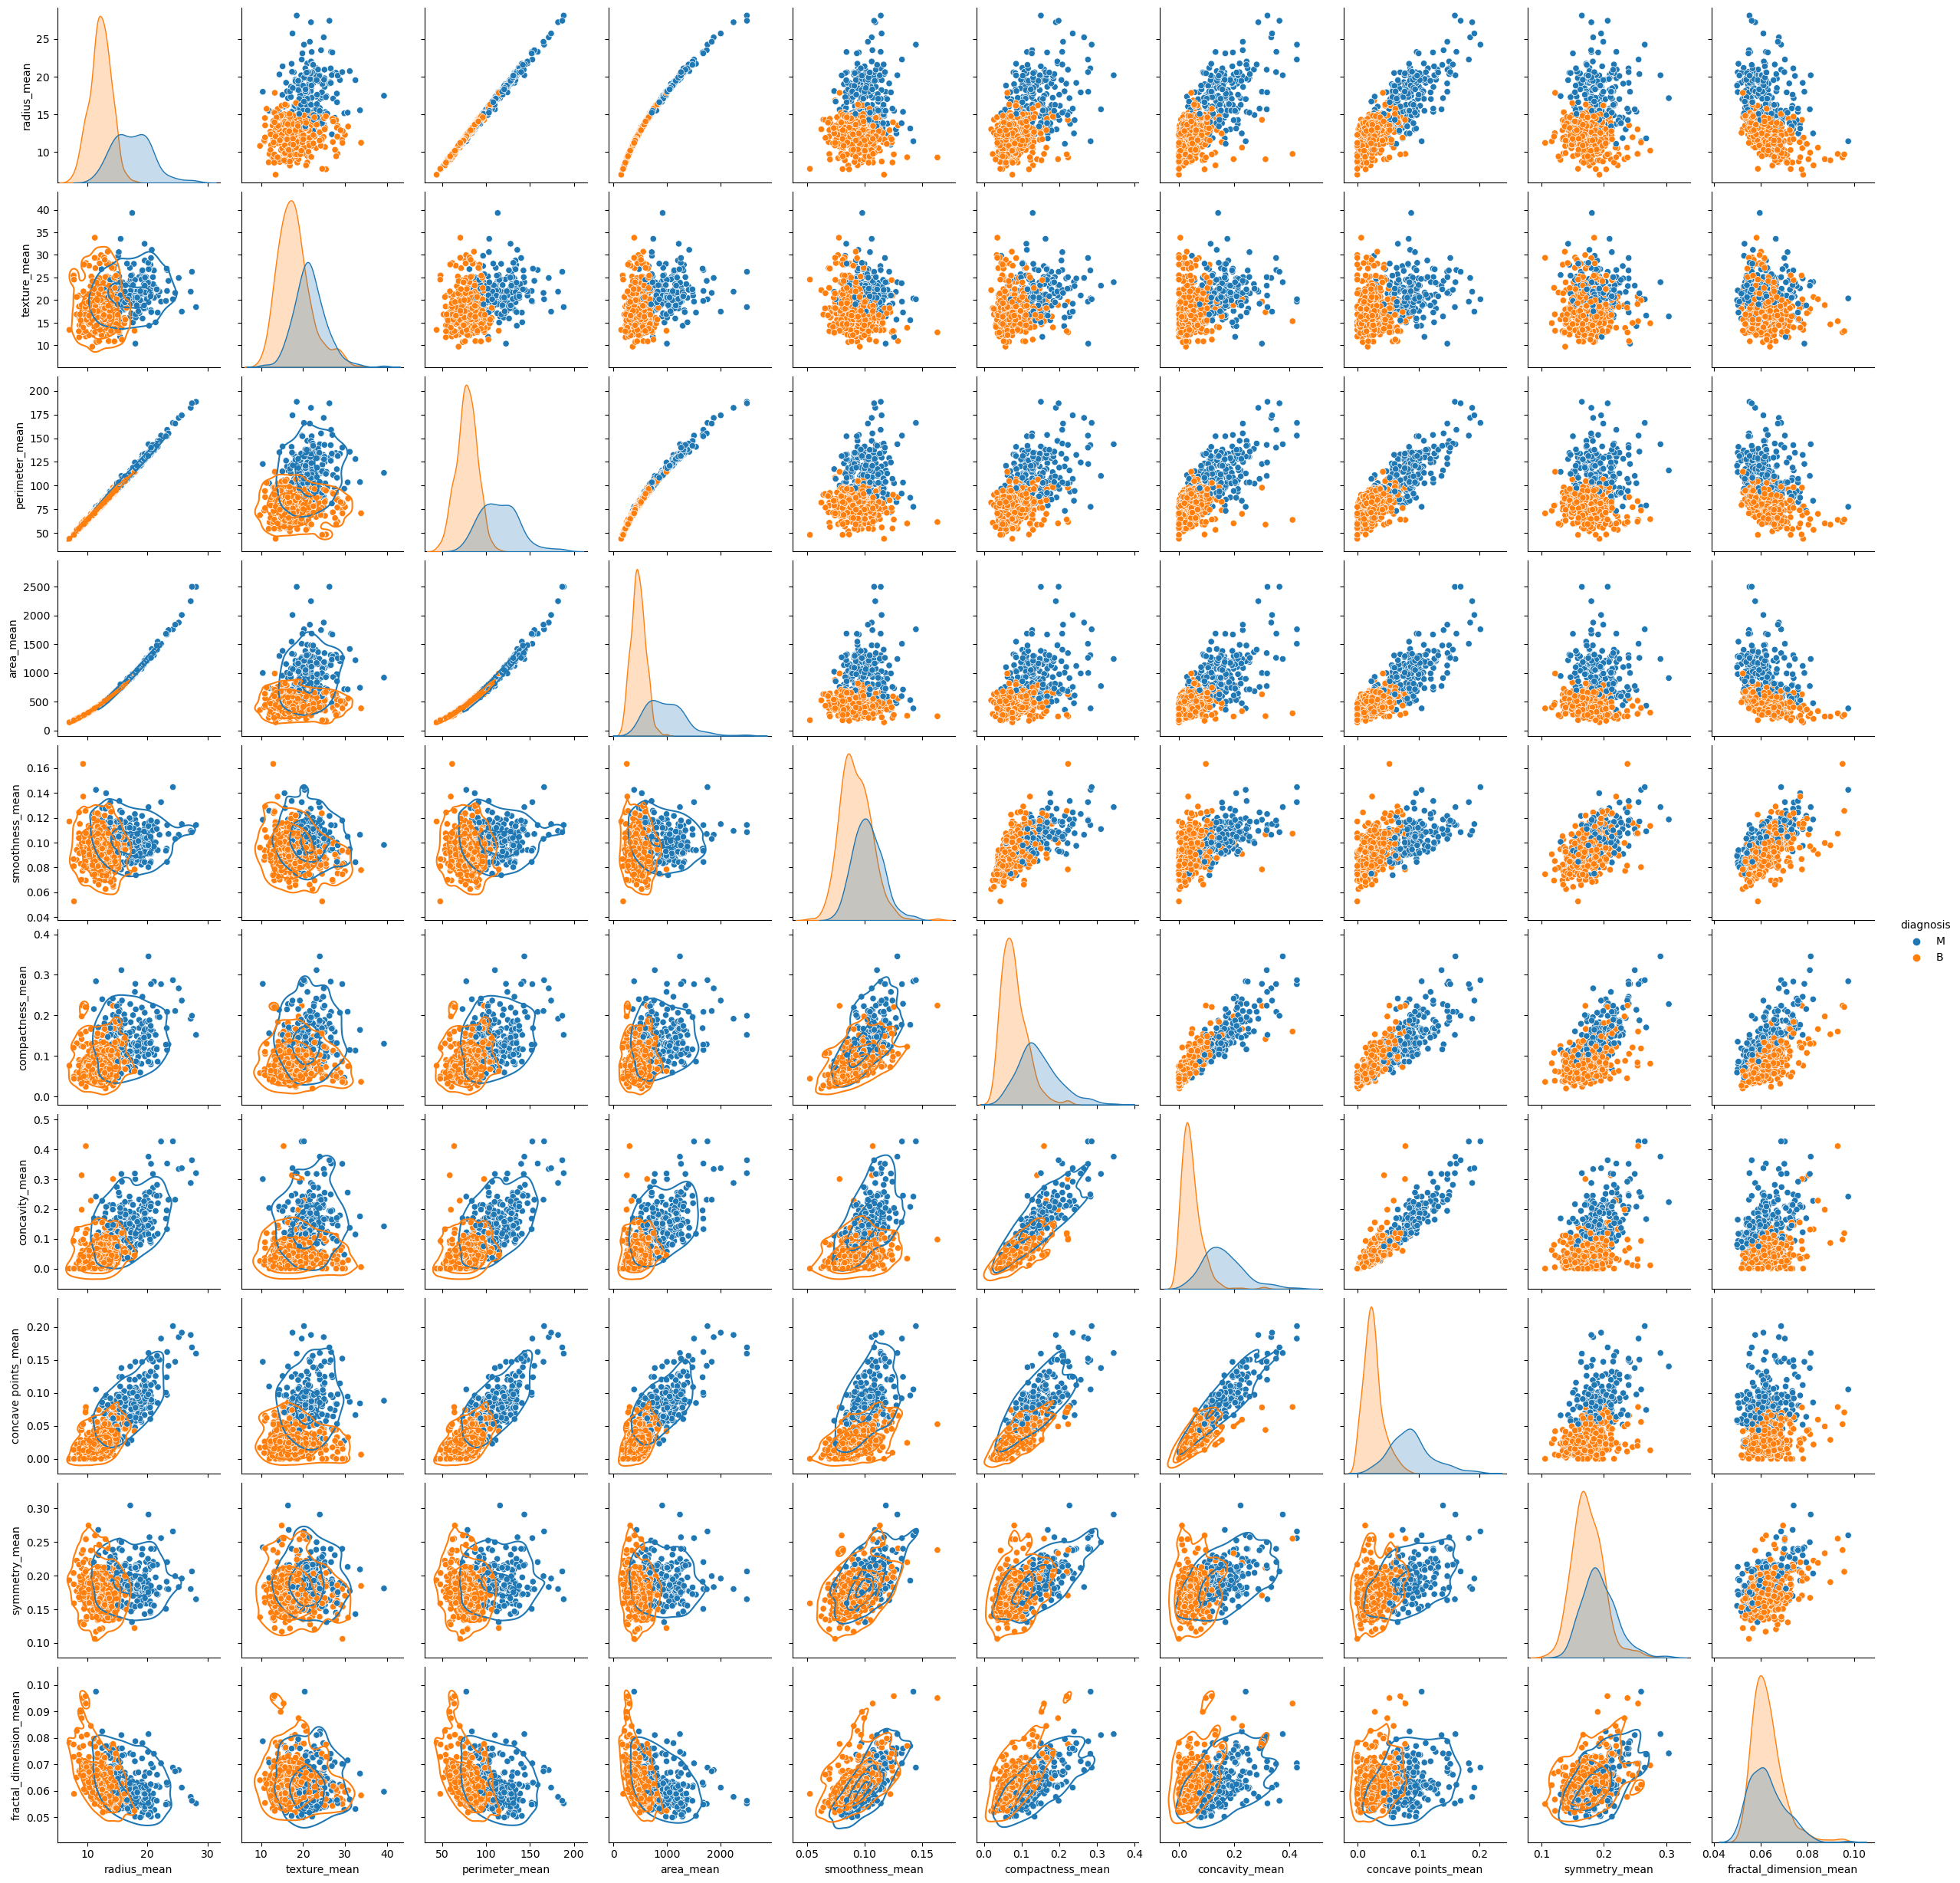

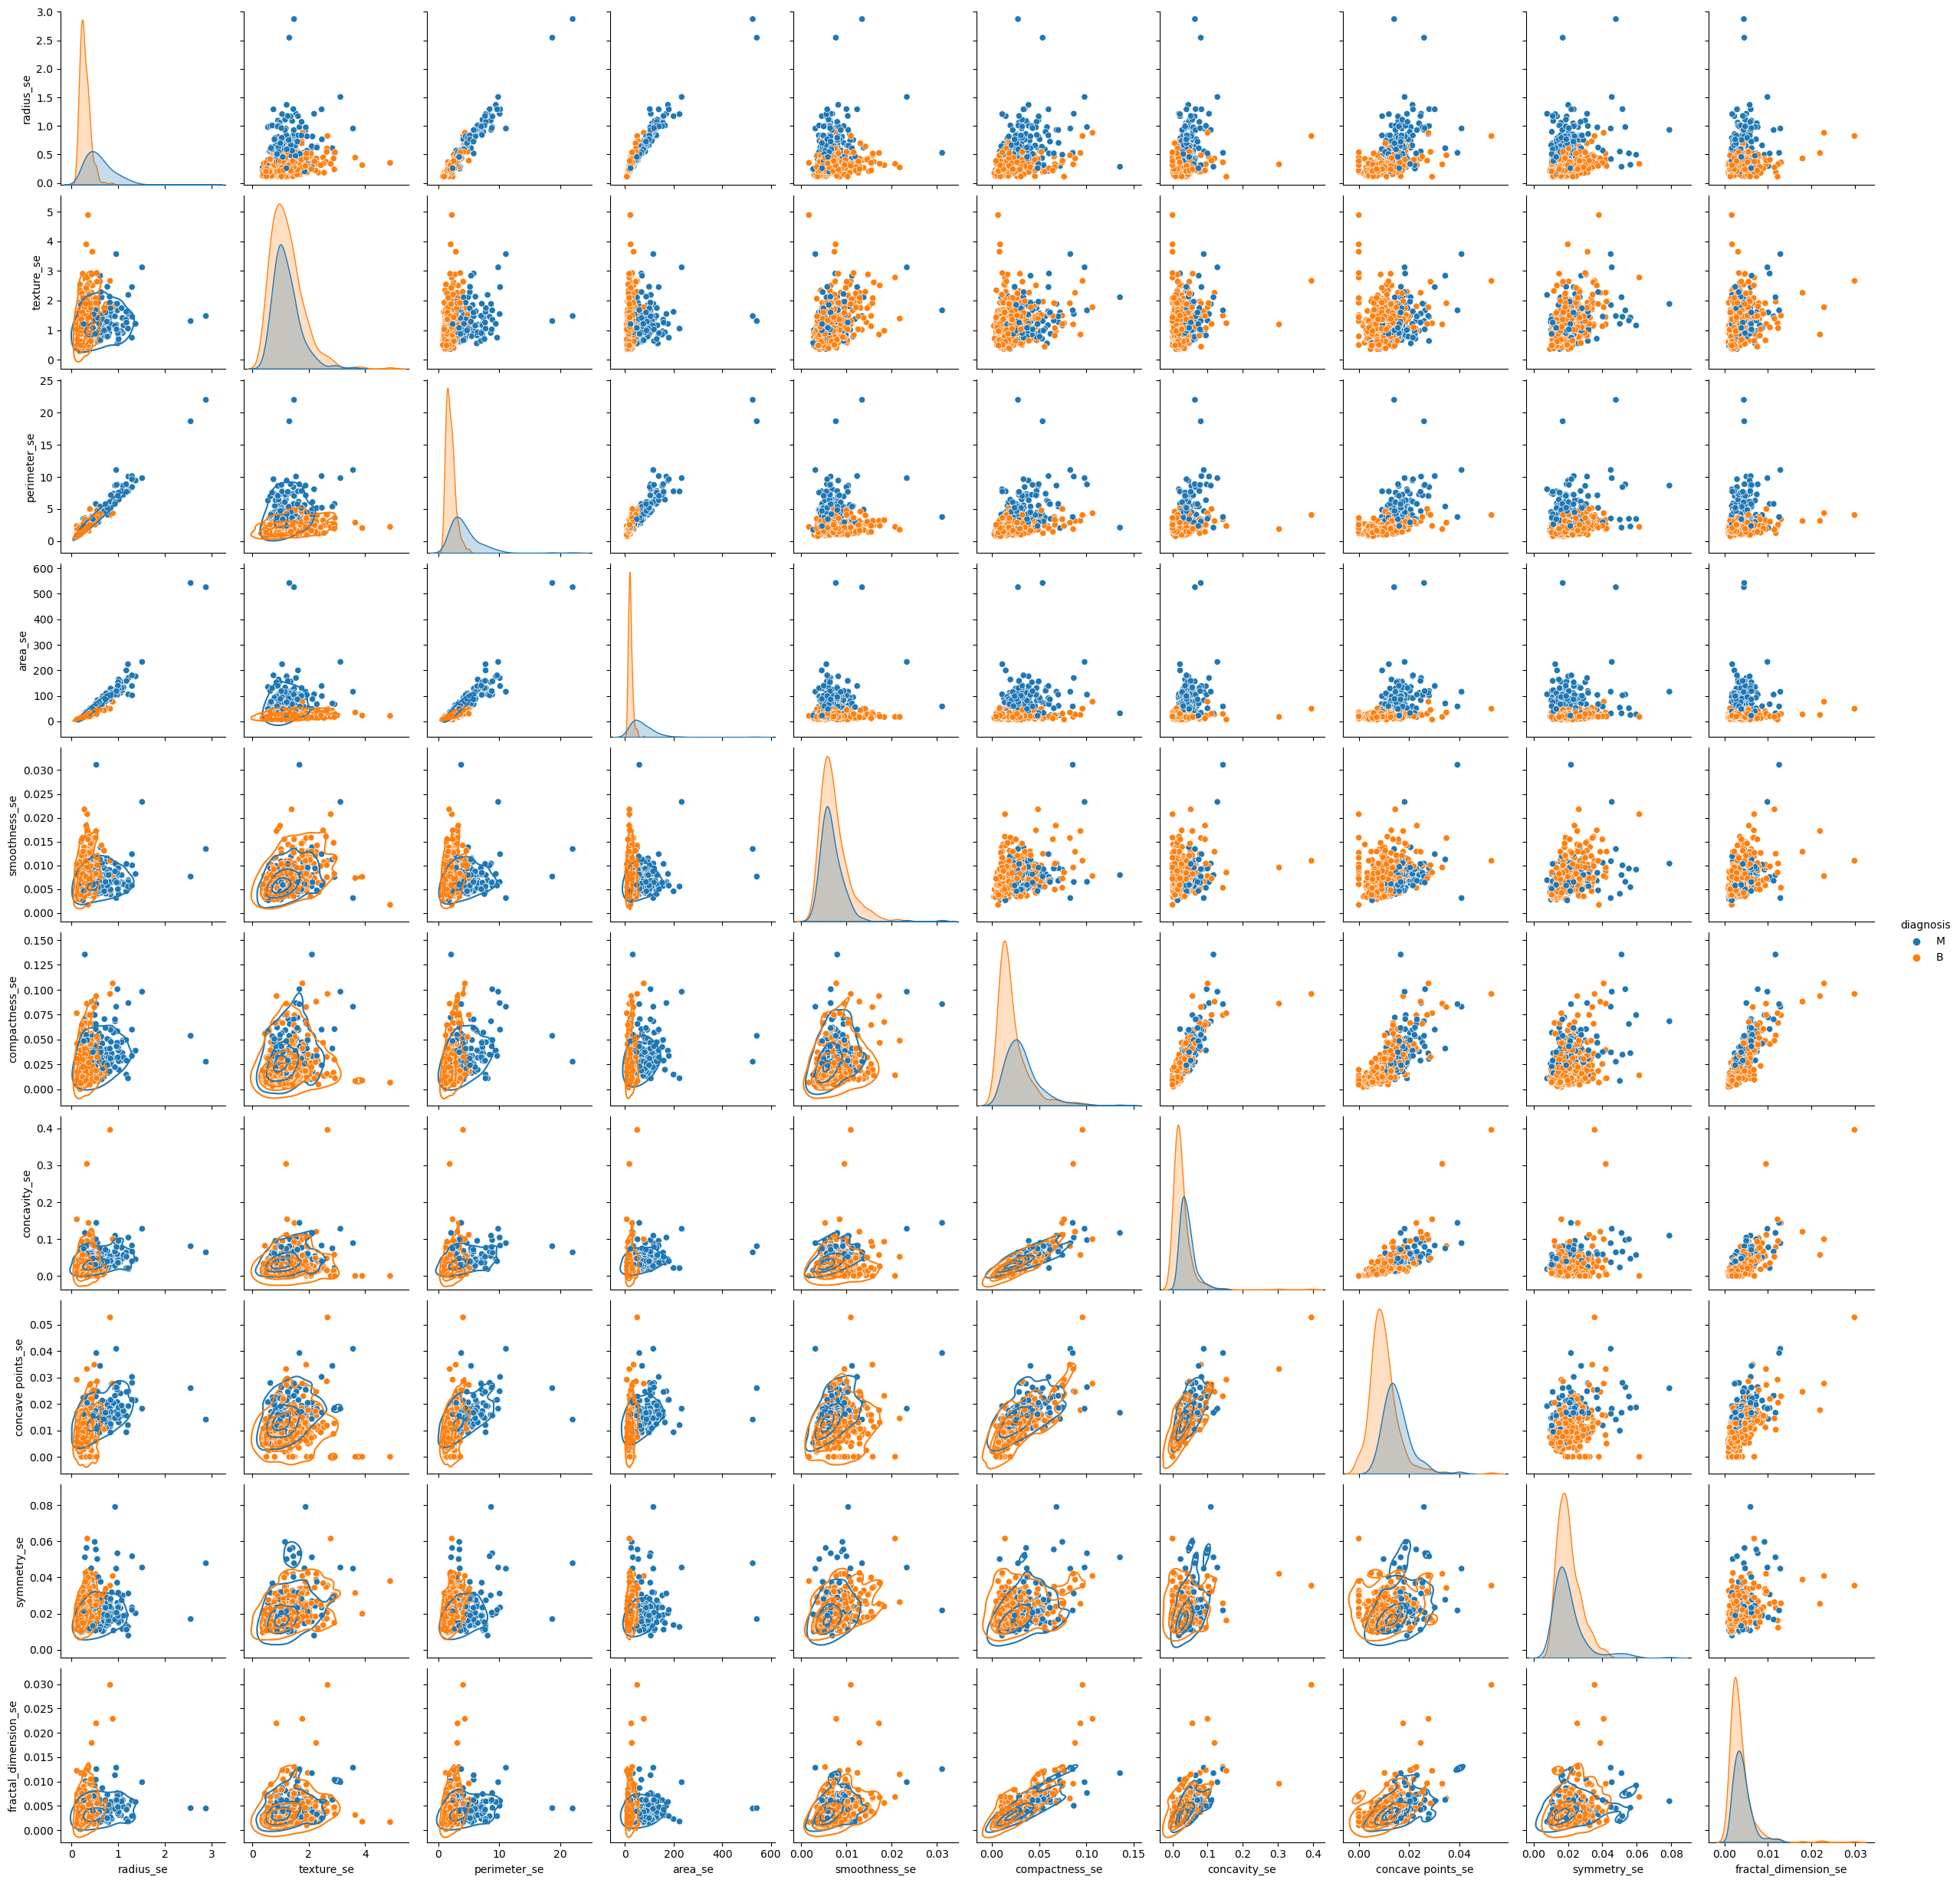

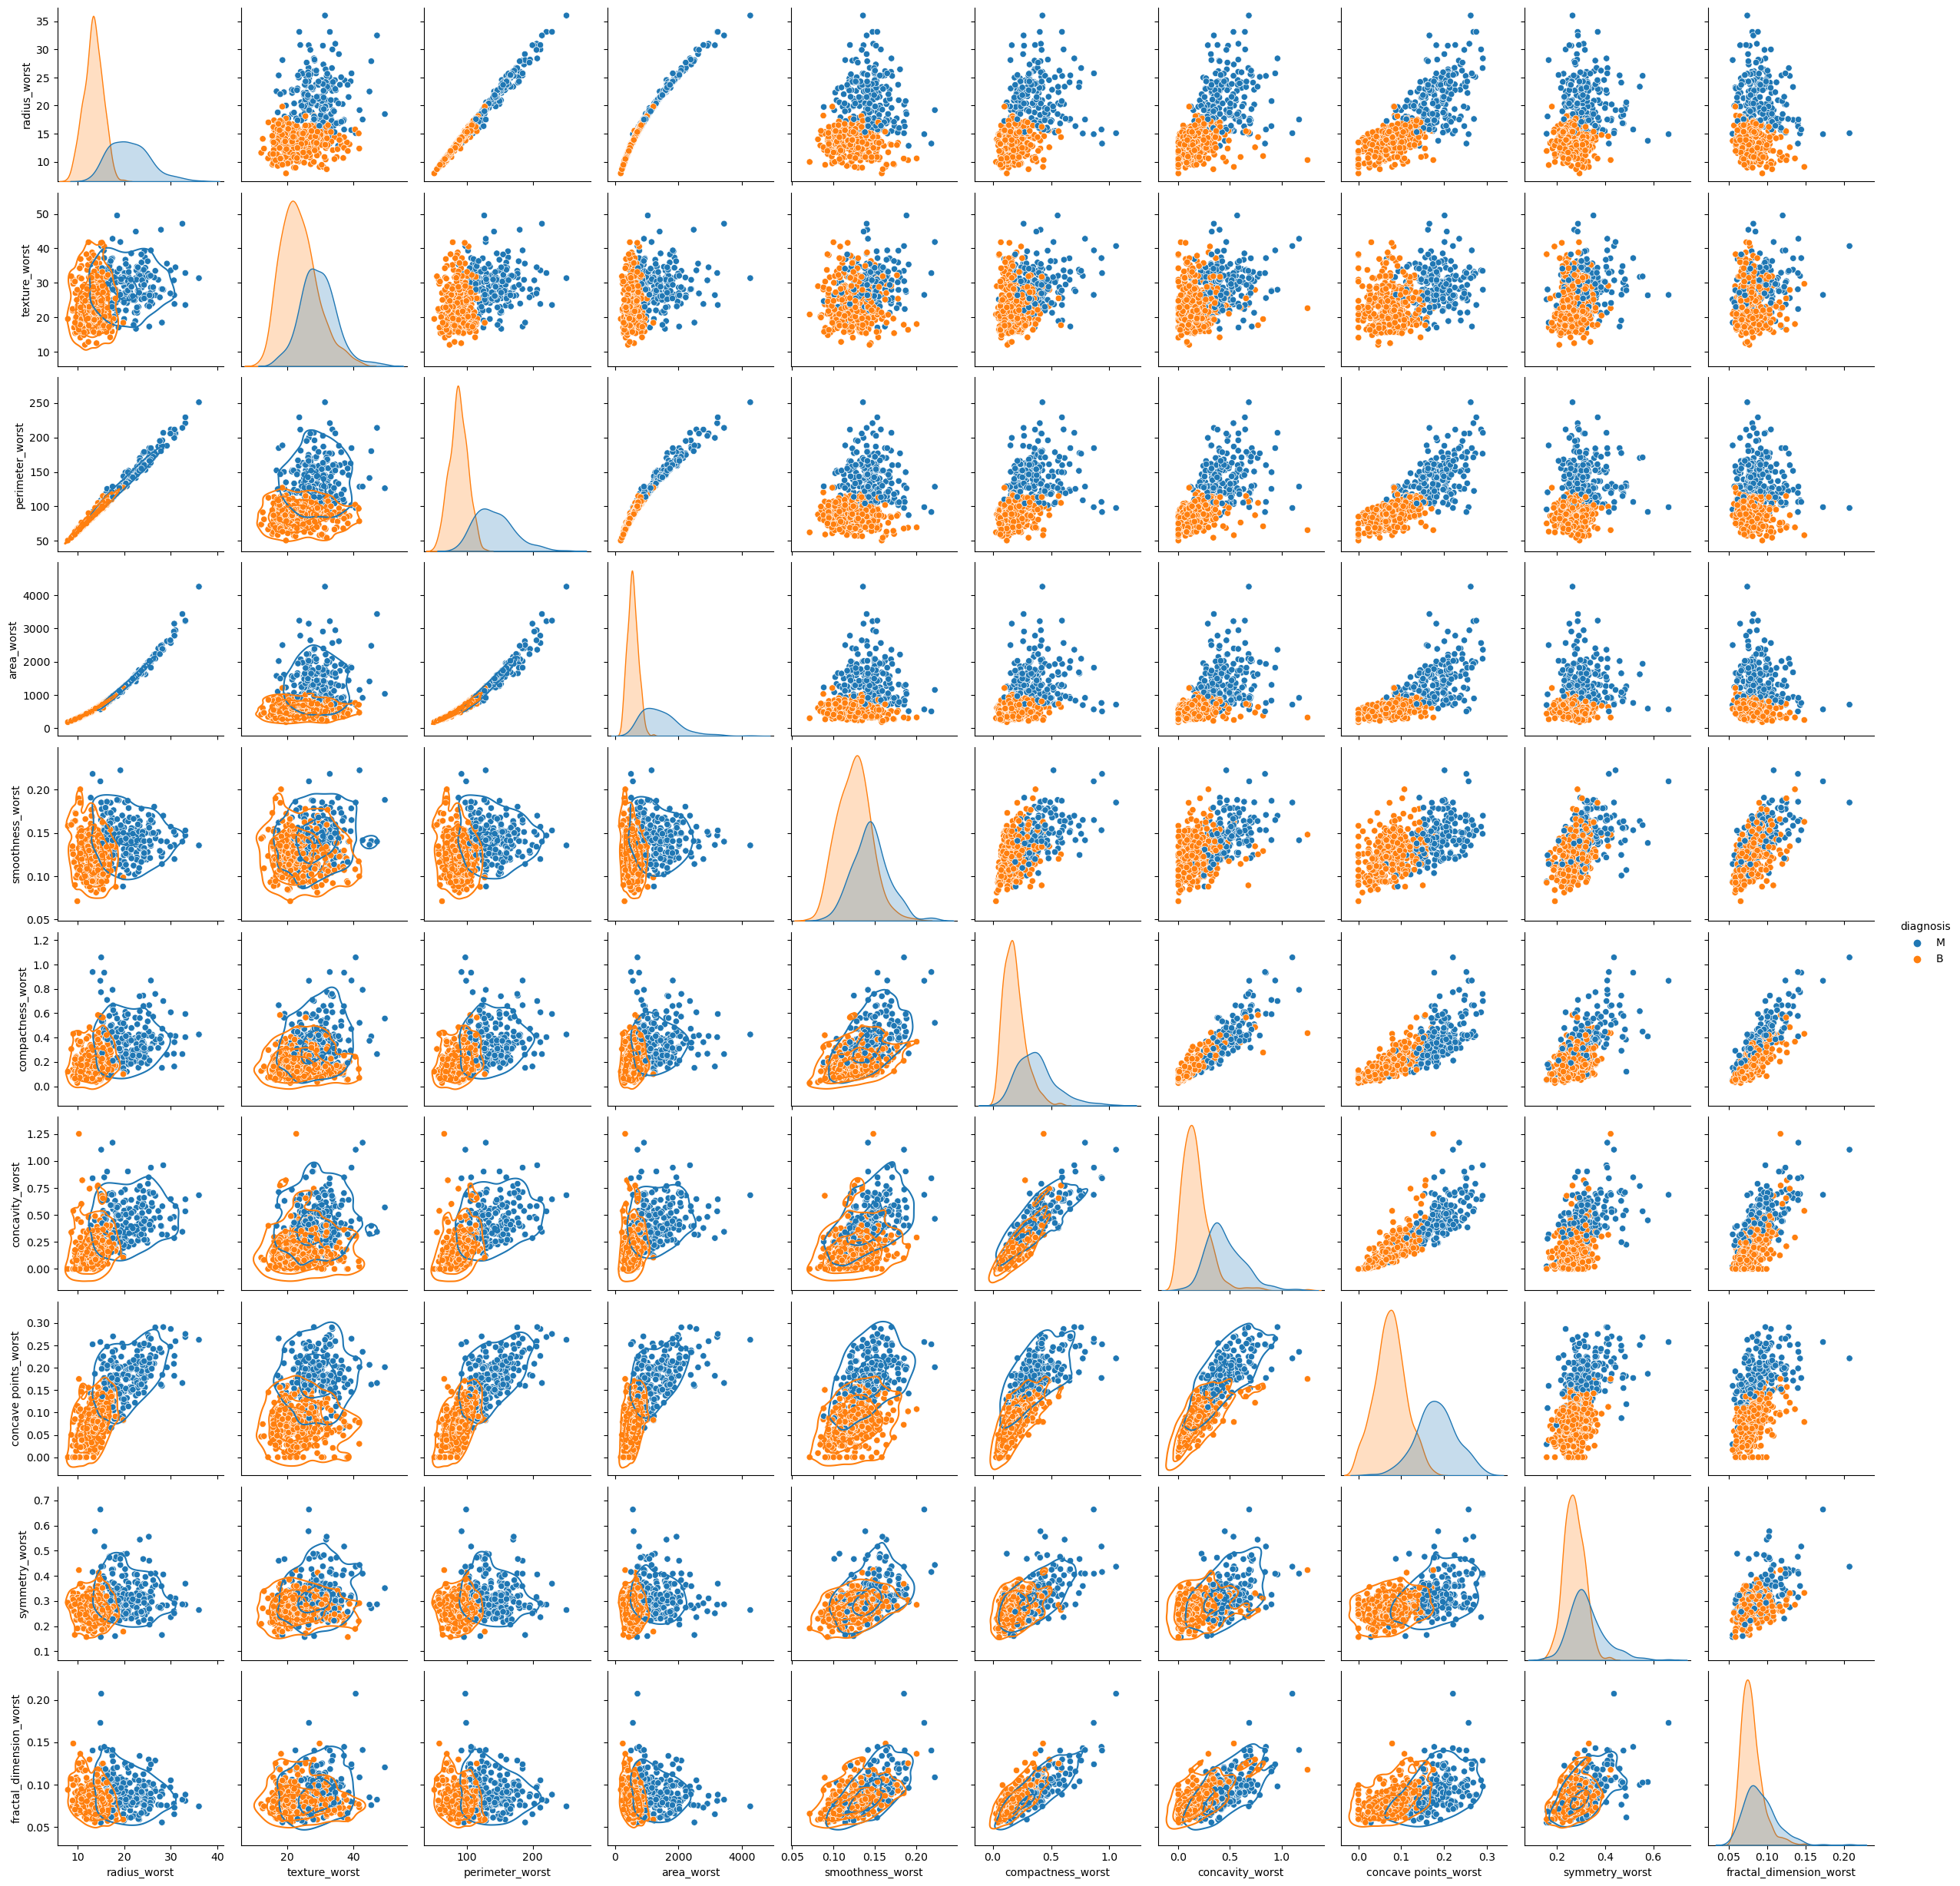

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

withdig = submean + ['diagnosis']
combineme = sns.pairplot(cddf[withdig], hue='diagnosis')
combineme.map_lower(sns.kdeplot, levels=4, color="0.2")
plt.show()

withdig = subse + ['diagnosis']
combineme = sns.pairplot(cddf[withdig], hue='diagnosis')
combineme.map_lower(sns.kdeplot, levels=4, color="0.2")
plt.show()

withdig = subworst + ['diagnosis']
combineme = sns.pairplot(cddf[withdig], hue='diagnosis')
combineme.map_lower(sns.kdeplot, levels=4, color="0.2")
plt.show()

## We need to also look at Mutual Information

Mutual information regression is run three times, means first, worst first, and SE first. The mutually most important feature order is agreed to on more than 10 of the features with the first difference being where the following summary stops around feature 18 and 19:

Mean, SE, Worst	Worst, SE, Mean	SE, Mean, Worst
perimeter_worst: 0.4747	perimeter_worst: 0.4800	perimeter_worst: 0.4764
area_worst: 0.4643	area_worst: 0.4653	area_worst: 0.4633
radius_worst: 0.4516	radius_worst: 0.4576	radius_worst: 0.4530
concave points_mean: 0.4416	concave points_mean: 0.4404	concave points_mean: 0.4405
concave points_worst: 0.4412	concave points_worst: 0.4319	concave points_worst: 0.4373
perimeter_mean: 0.4018	perimeter_mean: 0.4051	perimeter_mean: 0.4046
concavity_mean: 0.3782	concavity_mean: 0.3732	concavity_mean: 0.3736
radius_mean: 0.3663	radius_mean: 0.3667	radius_mean: 0.3699
area_mean: 0.3600	area_mean: 0.3611	area_mean: 0.3608
area_se: 0.3353	area_se: 0.3367	area_se: 0.3371
concavity_worst: 0.3165	concavity_worst: 0.3142	concavity_worst: 0.3163
perimeter_se: 0.2728	perimeter_se: 0.2776	perimeter_se: 0.2727
radius_se: 0.2432	radius_se: 0.2436	radius_se: 0.2457
compactness_worst: 0.2250	compactness_worst: 0.2248	compactness_worst: 0.2248
compactness_mean: 0.2136	compactness_mean: 0.2135	compactness_mean: 0.2124
concave points_se: 0.1279	concave points_se: 0.1331	concave points_se: 0.1330
texture_worst: 0.1224	texture_worst: 0.1217	texture_worst: 0.1211
concavity_se: 0.1177	smoothness_worst: 0.1133	concavity_se: 0.1125
smoothness_worst: 0.1000	concavity_se: 0.1108	smoothness_worst: 0.0987

[0.36704207 0.09720479 0.40463777 0.36027566 0.07923547 0.21167955
 0.37412133 0.43493231 0.06640196 0.00870168 0.2441968  0.00220842
 0.27071526 0.3373521  0.01842826 0.0757231  0.11783212 0.11802762
 0.01192549 0.03802394 0.45329982 0.11883992 0.47446728 0.46411801
 0.0983942  0.22537059 0.31705841 0.43650458 0.09343108 0.06599524]
perimeter_worst: 0.4745
area_worst: 0.4641
radius_worst: 0.4533
concave points_worst: 0.4365
concave points_mean: 0.4349
perimeter_mean: 0.4046
concavity_mean: 0.3741
radius_mean: 0.3670
area_mean: 0.3603
area_se: 0.3374
concavity_worst: 0.3171
perimeter_se: 0.2707
radius_se: 0.2442
compactness_worst: 0.2254
compactness_mean: 0.2117
texture_worst: 0.1188
concave points_se: 0.1180
concavity_se: 0.1178
smoothness_worst: 0.0984
texture_mean: 0.0972
symmetry_worst: 0.0934
smoothness_mean: 0.0792
compactness_se: 0.0757
symmetry_mean: 0.0664
fractal_dimension_worst: 0.0660
fractal_dimension_se: 0.0380
smoothness_se: 0.0184
symmetry_se: 0.0119
fractal_dimension_m

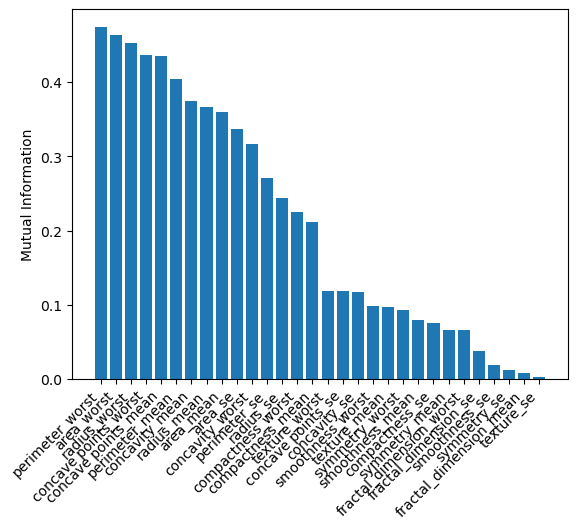

In [9]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression

# create a sample dataframe
#df = pd.DataFrame(np.random.rand(100, 4), columns=['feature1', 'feature2', 'feature3', 'feature4'])
X = cddf[submean + subse + subworst].copy()
target = cddf['diagnosis'].copy()
for i in range(len(target)):
    if target[i] == "M":
        target[i] = 1.0
    else:
        target[i] = 2.0
#pd.Series(np.random.rand(100))

# calculate mutual information
mi = mutual_info_regression(X, target)
print (mi)
# create a dictionary to store the mutual information for each feature
mi_dict = {}
for i, col in enumerate(X.columns):
    mi_dict[col] = mi[i]

# sort the dictionary in descending order
sorted_mi = {k: v for k, v in sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)}

# print the sorted mutual information values in descending order
for k, v in sorted_mi.items():
    print(f"{k}: {v:.4f}")

# plot the mutual information values in a bar chart
import matplotlib.pyplot as plt

plt.bar(sorted_mi.keys(), sorted_mi.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mutual Information')
plt.show()


[0.45449771 0.11931992 0.47456647 0.46470383 0.09787636 0.22444552
 0.30828352 0.43081343 0.0945539  0.06685441 0.24340593 0.
 0.27218505 0.33755153 0.01943247 0.07581531 0.11635538 0.12697678
 0.01118408 0.03570785 0.369311   0.09576065 0.40324264 0.35930539
 0.08397801 0.21289653 0.37764275 0.43687611 0.06356557 0.01133233]
perimeter_worst: 0.4746
area_worst: 0.4647
radius_worst: 0.4545
concave points_mean: 0.4369
concave points_worst: 0.4308
perimeter_mean: 0.4032
concavity_mean: 0.3776
radius_mean: 0.3693
area_mean: 0.3593
area_se: 0.3376
concavity_worst: 0.3083
perimeter_se: 0.2722
radius_se: 0.2434
compactness_worst: 0.2244
compactness_mean: 0.2129
concave points_se: 0.1270
texture_worst: 0.1193
concavity_se: 0.1164
smoothness_worst: 0.0979
texture_mean: 0.0958
symmetry_worst: 0.0946
smoothness_mean: 0.0840
compactness_se: 0.0758
fractal_dimension_worst: 0.0669
symmetry_mean: 0.0636
fractal_dimension_se: 0.0357
smoothness_se: 0.0194
fractal_dimension_mean: 0.0113
symmetry_se: 0.0

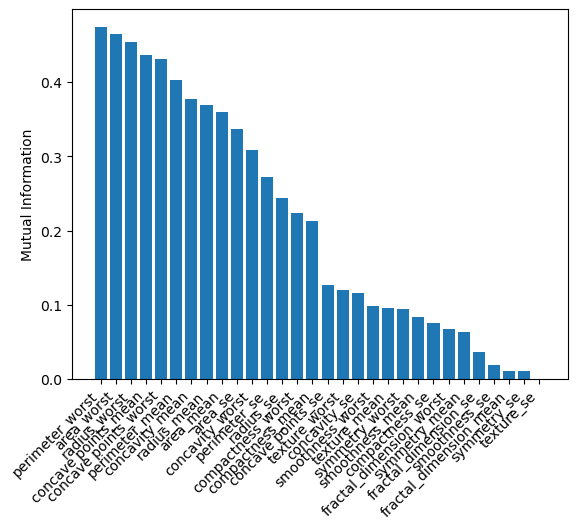

In [10]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression

# create a sample dataframe
#df = pd.DataFrame(np.random.rand(100, 4), columns=['feature1', 'feature2', 'feature3', 'feature4'])
X = cddf[subworst + subse + submean].copy()
target = cddf['diagnosis'].copy()
for i in range(len(target)):
    if target[i] == "M":
        target[i] = 1.0
    else:
        target[i] = 2.0
#pd.Series(np.random.rand(100))

# calculate mutual information
mi = mutual_info_regression(X, target)
print (mi)
# create a dictionary to store the mutual information for each feature
mi_dict = {}
for i, col in enumerate(X.columns):
    mi_dict[col] = mi[i]

# sort the dictionary in descending order
sorted_mi = {k: v for k, v in sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)}

# print the sorted mutual information values in descending order
for k, v in sorted_mi.items():
    print(f"{k}: {v:.4f}")

# plot the mutual information values in a bar chart
import matplotlib.pyplot as plt

plt.bar(sorted_mi.keys(), sorted_mi.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mutual Information')
plt.show()

[0.24613255 0.00106603 0.27256945 0.3386212  0.01840017 0.0732459
 0.11501481 0.12632374 0.01191813 0.03507809 0.36381773 0.09457568
 0.40302702 0.3592245  0.08235943 0.21276183 0.36996334 0.43666801
 0.06793013 0.00808438 0.45715577 0.11937774 0.4774812  0.46320999
 0.10116888 0.22454874 0.31068436 0.43322566 0.09029146 0.06568665]
perimeter_worst: 0.4775
area_worst: 0.4632
radius_worst: 0.4572
concave points_mean: 0.4367
concave points_worst: 0.4332
perimeter_mean: 0.4030
concavity_mean: 0.3700
radius_mean: 0.3638
area_mean: 0.3592
area_se: 0.3386
concavity_worst: 0.3107
perimeter_se: 0.2726
radius_se: 0.2461
compactness_worst: 0.2245
compactness_mean: 0.2128
concave points_se: 0.1263
texture_worst: 0.1194
concavity_se: 0.1150
smoothness_worst: 0.1012
texture_mean: 0.0946
symmetry_worst: 0.0903
smoothness_mean: 0.0824
compactness_se: 0.0732
symmetry_mean: 0.0679
fractal_dimension_worst: 0.0657
fractal_dimension_se: 0.0351
smoothness_se: 0.0184
symmetry_se: 0.0119
fractal_dimension_me

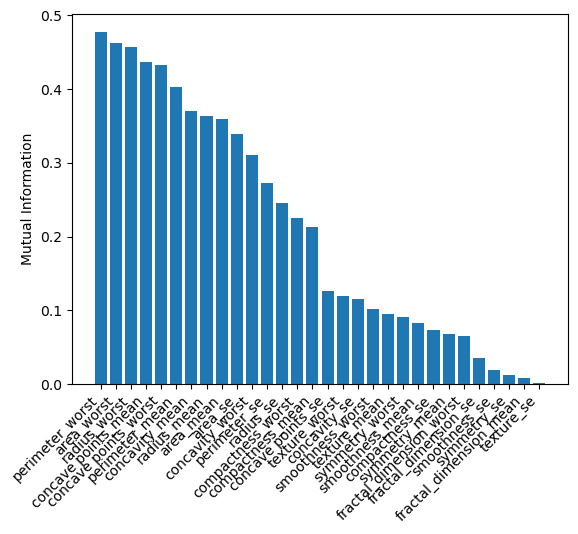

In [11]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression

# create a sample dataframe
#df = pd.DataFrame(np.random.rand(100, 4), columns=['feature1', 'feature2', 'feature3', 'feature4'])
X = cddf[subse + submean + subworst].copy()
target = cddf['diagnosis'].copy()
for i in range(len(target)):
    if target[i] == "M":
        target[i] = 1.0
    else:
        target[i] = 2.0
#pd.Series(np.random.rand(100))

# calculate mutual information
mi = mutual_info_regression(X, target)
print (mi)
# create a dictionary to store the mutual information for each feature
mi_dict = {}
for i, col in enumerate(X.columns):
    mi_dict[col] = mi[i]

# sort the dictionary in descending order
sorted_mi = {k: v for k, v in sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)}

# print the sorted mutual information values in descending order
for k, v in sorted_mi.items():
    print(f"{k}: {v:.4f}")

# plot the mutual information values in a bar chart
import matplotlib.pyplot as plt

plt.bar(sorted_mi.keys(), sorted_mi.values())
plt.xticks(rotation=45, ha='right')
plt.ylabel('Mutual Information')
plt.show()

## Setting up Feature List for training

Here we are proceeding with training a deep neural network on the features where mutual information seems highest and agreed to regardless of the order in which the features are presented. Some concern exists that the measurements of area, radios, and perimeter will have linear relationships affecting the model. We will test for overfitting, or underfitting, at the end.

The 19 features in general agreement of mutual information analysis above (down to the last rows 18 and 19 which disagreed) are included in a feature set for training (see trainOnMe).



In [12]:
trainOnMe = ['perimeter_worst', 'area_worst', 'radius_worst', 'concave points_mean', 'concave points_worst', 
             'perimeter_mean', 'concavity_mean', 'radius_mean', 'area_mean', 'area_se', 'concavity_worst',
             'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'concave points_se',
             'texture_worst', 'concavity_se', 'smoothness_worst']

X = cddf[trainOnMe].copy()
target = cddf['diagnosis'].copy()
for i in range(len(target)):
    if target[i] == "M":
        target[i] = 0.0
    else:
        target[i] = 1.0

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

y = tf.keras.utils.to_categorical(target, num_classes=len([0, 1]))

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0.0), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, trainOnMe),
    # (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, 
                     stratify=y, 
                     train_size=0.7)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
print("The input shape is ", input_shape)

The input shape is  [19]


Setting up the tensorflow neural network for X inputs, and 2 outputs. The output is one neuron each for the two categorical states of the Diagnosis. The inputs are 19 continous features in TrainOnMe. The hidden layers are given enough density to allow a weight from each feature to all other features (19 features to 18 each).

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[19]),
    layers.Dense(19, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(19, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    #layers.Flatten(),
    layers.Dense(19, activation='relu'),
    layers.Dense(2, activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    #loss='categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/200
8/8 [==============================] - 3s 52ms/step - loss: 0.7253 - accuracy: 0.5628 - val_loss: 0.6513 - val_accuracy: 0.7076
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 0.6231 - accuracy: 0.6834 - val_loss: 0.6145 - val_accuracy: 0.8012
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 0.5735 - accuracy: 0.7513 - val_loss: 0.5799 - val_accuracy: 0.8421
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 0.5310 - accuracy: 0.7915 - val_loss: 0.5443 - val_accuracy: 0.8538
Epoch 5/200
8/8 [==============================] - 0s 10ms/step - loss: 0.4613 - accuracy: 0.8518 - val_loss: 0.5090 - val_accuracy: 0.8772
Epoch 6/200
8/8 [==============================] - 0s 11ms/step - loss: 0.4499 - accuracy: 0.8417 - val_loss: 0.4719 - val_accuracy: 0.8947
Epoch 7/200
8/8 [==============================] - 0s 10ms/step - loss: 0.4137 - accuracy: 0.8744 - val_loss: 0.4366 - val_accuracy: 0.9064
Epoch 8/200
8/8 [====

<AxesSubplot:>

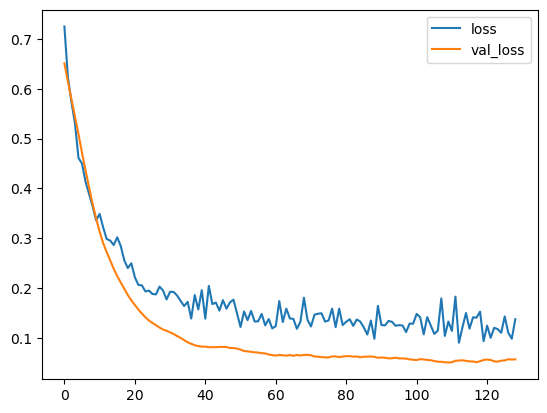

In [15]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=int(len(X)/10),
    epochs=200,
    callbacks=[early_stopping],
)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_valid, y_valid)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()

## Let's check accuracy of the model on how well it predicts the same outcome for all known samples

The 100% accuracy may be a one off of tha training split. Let's see how well the model does at reproducing the results for the entire set of samples available to us.

In [16]:
transformer_num = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0.0), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value=0),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, trainOnMe),
    #(transformer_cat, features_cat),
)

X_all = X.copy()

X_all = preprocessor.fit_transform(X_all)

y_pred = model.predict(X_all) # run a prediction on all rows

print(y_pred) # reminder, one over 0.5 is the answer [ neutral positive negative ]

finaldf = cddf.copy()

finaldf['NN-diagnosis'] = "unknown"

total_changed = 0
total_true_pos = 0
total_pos2neg = 0
total_true_neg = 0
total_neg2pos = 0
for i in range(len(finaldf)):
    if i % 100 == 0:
        print("Updating DF results completed ", i, " of ", len(finaldf))
    if y_pred[i][0] >= 0.5: # prediction is now neutral
        finaldf.loc[i, "NN-diagnosis"] = "M"
        if finaldf.loc[i, "diagnosis"] == "B":
            total_changed = total_changed + 1
            total_pos2neg = total_pos2neg + 1
        else:
            total_true_pos += 1
    elif y_pred[i][1] >= 0.5: # prediction is now positive
        finaldf.loc[i, "NN-diagnosis"] = "B"
        if finaldf.loc[i, "diagnosis"] == "M":
            total_changed = total_changed + 1
            total_neg2pos = total_neg2pos + 1
        else:
            total_true_neg += 1
             
print("There were a total of ", total_changed, " changes in diagnosis")
print("Accuracy against the full training set is ", 1.0 - (total_changed / len(finaldf)))
print(" ")
print("Total changed from positive to negative ", total_pos2neg)
print("Total changed from negative to positive ", total_neg2pos)
print("True positives ", total_true_pos)
print("True negatives ", total_true_neg)

18/18 [==============================] - 0s 2ms/step
[[9.9999636e-01 3.6036838e-06]
 [9.9988753e-01 1.1235252e-04]
 [9.9997562e-01 2.4261199e-05]
 ...
 [9.9893075e-01 1.0692843e-03]
 [9.9999899e-01 9.7681061e-07]
 [6.0444663e-06 9.9999392e-01]]
Updating DF results completed  0  of  569
Updating DF results completed  100  of  569
Updating DF results completed  200  of  569
Updating DF results completed  300  of  569
Updating DF results completed  400  of  569
Updating DF results completed  500  of  569
There were a total of  12  changes in diagnosis
Accuracy against the full training set is  0.9789103690685413
 
Total changed from positive to negative  3
Total changed from negative to positive  9
True positives  203
True negatives  354


In [17]:
observed_agreement = (total_true_pos + total_true_neg) / \
                (total_true_pos + total_true_neg + total_pos2neg + total_neg2pos)

print ("Calculated Observed Agreement =", observed_agreement)

chance_agreement = \
    ((total_true_pos + total_pos2neg) * (total_true_pos + total_neg2pos) + \
     (total_true_neg + total_pos2neg) * (total_true_neg + total_neg2pos)) / \
    ((total_true_pos + total_true_neg + total_pos2neg + total_neg2pos) * \
     (total_true_pos + total_true_neg + total_pos2neg + total_neg2pos))

print ("Calculated Chance Agreement =", chance_agreement)

kappa = (observed_agreement - chance_agreement) / (1 - chance_agreement)

print ("Cohen's Kappa=", kappa)

Calculated Observed Agreement = 0.9789103690685413
Calculated Chance Agreement = 0.535157106631126
Cohen's Kappa= 0.9546306263206157
